In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from fastai.vision.all import *
from torchvision import transforms
import torchvision.transforms.functional as TF
import ipywidgets as widgets
from PIL import Image as pilImage
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
sys.path.append("../") 
%load_ext autoreload
%autoreload 2
from src.utils import *
from src.gradcam import GuidedGradCam
from src.augmentationImpactAnalyzer import AugmentationImpactAnalyzer 

ROOT_DIR =  Path('../')
DATA_PATH = ROOT_DIR/'data/'
IMGS_PATH = ROOT_DIR/'imgs/'

## Prepare Simple Regression Model

The following model learns to count how many pixels are white. 

In [2]:
np.random.seed(0)
torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

In [3]:
def generate_counting_data(data_length,sample_length,max_count):
    data = np.zeros((data_length,sample_length))
    for i in range(len(data)):
        tt = np.zeros(sample_length)
        idx = np.random.choice(np.arange(0,sample_length),np.random.randint(1,max_count),replace=False)
        tt.put(idx,1)
        data[i] = tt
    return data

sample_length = 32*32
data_length = 10000
max_count = sample_length//3
train_data = generate_counting_data(data_length, sample_length, max_count)
valid_data = generate_counting_data(data_length, sample_length, max_count)

class CountingTestdataset(torch.utils.data.Dataset):
    def __init__(self, input_data):
        self.input_data = input_data
               
    def __getitem__(self, i):
        x = self.input_data[i]
        return torch.stack([x.view(32,32)]*3), self.input_data[i].sum()
    
    def __len__(self): return len(self.input_data)-1
train_ds = CountingTestdataset(torch.Tensor(train_data))
valid_ds = CountingTestdataset(torch.Tensor(valid_data))
dls = DataLoaders.from_dsets(train_ds, valid_ds,bs=9)

In [4]:
class SimpleCounter(nn.Module):
    # works only with fixed input size
    def __init__(self,input_size, ):
        super(SimpleCounter, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(3,15,3,padding=1),
                                     nn.ReLU())
        self.head = nn.Sequential(#nn.AdaptiveAvgPool2d((1, 1)),
                        nn.Flatten(),
                        nn.Linear(input_size,1)
                        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = torch.max(x,axis=1,keepdim=True).values
        return self.head(x)
counter = SimpleCounter(input_size=32*32)
learn = Learner(dls, counter, loss_func=L1LossFlat(), metrics=mae)
learn.fit_one_cycle(5, 0.01) 

epoch,train_loss,valid_loss,mae,time
0,1.916783,1.144941,1.144941,00:08
1,2.224992,2.745855,2.745855,00:08
2,1.309809,1.894809,1.894809,00:08
3,0.646018,0.545525,0.545525,00:08
4,0.423689,0.414754,0.414754,00:08


In [5]:
ggc = GuidedGradCam(counter,use_cuda,target_type='regression', layer_ids=['encoder.0', 'head.2'])
input = train_ds[0][0].unsqueeze(0)
heatmap, gb, cam_gb = ggc(input.requires_grad_(True))     

register hooks for:
encoder.0


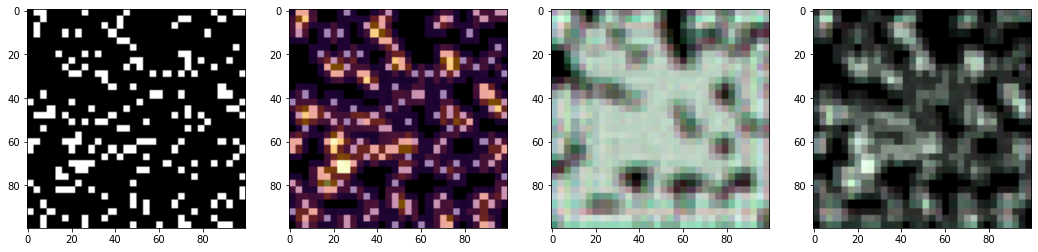

In [6]:
img = transforms.ToPILImage()(input[0])

fig, ax = plt.subplots(1,4,figsize=(18,6))
ax[0].imshow(img.reshape(100,100))
cam = np.float32(img)+np.float32(heatmap)
ax[1].imshow(arr_to_img(cam).reshape(100,100))
ax[2].imshow(arr_to_img(gb).reshape(100,100))
ax[3].imshow(arr_to_img(cam_gb).reshape(100,100))
plt.show()

## AugmentationImpactAnalyzer

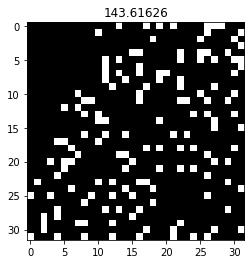

In [7]:
input = valid_ds[0][0].unsqueeze(0)
img = transforms.ToPILImage()(input[0])

aia = AugmentationImpactAnalyzer(img, counter, guided_grad_cam=ggc)
aia.tfms(erase_w=10,erase_h=10,rotate_ang=90,activation_localization=None)

In [8]:
width, height = aia.img.shape

import ipywidgets as widgets
def create_gif_on_click(change):
    os.makedirs('../imgs/',exist_ok=True)
    aia.create_gif(IMGS_PATH/'results.gif')

btn_create_gif = widgets.Button(description='Create gif')
btn_create_gif.on_click(create_gif_on_click)

btn_act_loc = widgets.RadioButtons(
    options=['none','gradcam','guided-gradient','guided-gradcam',],
    description='Activation Localization:',
    disabled=False)

sl_brightness = widgets.FloatSlider(value=1,min=0.1,max=4,step=0.2)
box_brightness = widgets.VBox([widgets.HTML('<em>Brightness</em>'),sl_brightness])

sl_crop_size = widgets.IntSlider(value=width,min=32,max=width,step=5)
box_crop = widgets.VBox([widgets.HTML('<em>Center Crop</em>'),sl_crop_size])

sl_rotate = widgets.IntSlider(value=0,min=0,max=360,step=5)
box_rotate = widgets.VBox([widgets.HTML('<em>Rotation Angle</em>'),sl_rotate])
sl_perspective_w = widgets.IntSlider(value=width,min=0,max=width,step=5)
sl_perspective_h = widgets.IntSlider(value=height,min=0,max=height,step=5)
sl_perspective_d = widgets.IntSlider(value=0,min=0,max=height,step=5)
box_perspective = widgets.VBox([widgets.HTML('<em>Perspective Distortion</em>'),sl_perspective_w,sl_perspective_h,sl_perspective_d])

sl_erase_i = widgets.IntSlider(value=0,min=0,max=width,step=1)
sl_erase_j = widgets.IntSlider(value=0,min=0,max=height,step=1)
sl_erase_w = widgets.IntSlider(value=0,min=0,max=height,step=1)
sl_erase_h = widgets.IntSlider(value=0,min=0,max=height,step=1)
box_erase = widgets.VBox([widgets.HTML('<em>Erase Box</em>'),sl_erase_i,sl_erase_j,sl_erase_w, sl_erase_h])

btn_upload = widgets.FileUpload(description='Your Image')

tfm_args_sl = { "brightness":sl_brightness,
                "crop_size":sl_crop_size,
                "activation_localization":btn_act_loc, 
                "rotate_ang":sl_rotate,
                "perspective_w":sl_perspective_w,
                "perspective_h":sl_perspective_h,
                "perspective_d":sl_perspective_d,
                "erase_i":sl_erase_i,
                "erase_j":sl_erase_j,
                "erase_w":sl_erase_w,
                "erase_h":sl_erase_h}
#tfm_args = {k:v.value for k,v in tfm_args_sl.items()}

In [9]:
#aia.reset(PILImage.create((path/"train/n02102040").ls()[32]).resize((size,size)))  
aia.reset(img)
out_tfms = widgets.interactive_output(aia.tfms, tfm_args_sl)
gui = widgets.HBox([widgets.VBox([btn_upload, box_brightness, box_crop, box_rotate, box_perspective, box_erase,
                            btn_act_loc, btn_create_gif]), out_tfms])

def on_upload_change(change):
    aia.reset(PILImage.create(btn_upload.data[-1]))
    if btn_act_loc.value != 'none':
        btn_act_loc.value = 'none'
    else:
        # quick (ugly) hack to reload the image for sure
        if sl_crop_size.value != width:
            sl_crop_size.value = width
        else:
            sl_crop_size.value = sl_crop_size.value - sl_crop_size.step 
    #aia.tfms(**tfm_args) #doesn't reset the gui output

btn_upload.observe(on_upload_change, names='_counter')
display(gui)

[Open Gif](../imgs/results.gif "segment")
